In [227]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import PIL
import glob
import imageio
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
!pip install -q tensorflow-probability

In [269]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

latent_dim=64
num_outputs = 10

**Autoencoder**

In [270]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim 
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder = Autoencoder(latent_dim)

In [271]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                  epochs=10,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0239 - val_loss: 0.0093
Epoch 2/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0069 - val_loss: 0.0054
Epoch 3/10
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0051 - val_loss: 0.0046
Epoch 4/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0045 - val_loss: 0.0043
Epoch 5/10
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0043 - val_loss: 0.0041
Epoch 6/10
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
60000/60000 [==============================] - 6s 101us/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 8/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0040 -

In [272]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

**Variational Autoencoder**

In [260]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
optimizer = tf.keras.optimizers.Adam(1e-4)
train_images = train_images.astype('float32') #/ 255.
test_images = test_images.astype('float32') #/ 255.

In [261]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [262]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [263]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [264]:
random_vector_for_generation = tf.random.normal(
    shape=[num_outputs, latent_dim])
model = CVAE(latent_dim)

In [265]:
for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  print(epoch)

1
2
3
4
5
6
7
8
9
10
11
12


**Compare Output**

In [266]:
mean, logvar = model.encode(test_x)
predictions = model.sample(model.reparameterize(mean, logvar))
predictions = tf.reshape(predictions, [16, 28, 28])

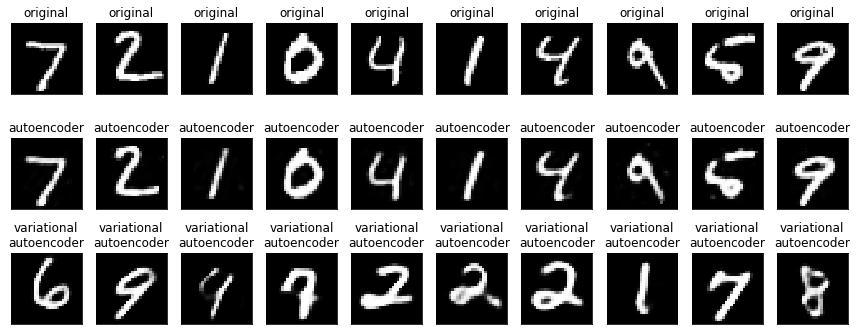

In [277]:
plt.figure(figsize=(15, 6))
for i in range(num_outputs):
  # display original
  ax = plt.subplot(3, num_outputs, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display original
  ax = plt.subplot(3, num_outputs, i + 1 + num_outputs)
  plt.imshow(decoded_imgs[i])
  plt.title("autoencoder")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, num_outputs, i + 1 + 2*num_outputs)
  plt.imshow(predictions[i])
  plt.title("variational\nautoencoder")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()